In [1]:
from google.colab import drive

drive.mount('/MyDrive')

!ls

Mounted at /MyDrive
sample_data


In [2]:
from keras.engine import input_layer
import numpy as np
import cv2
import tensorflow as tf
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

data_path = '/MyDrive/MyDrive/alzheimer/dataset/Task_01_with/'
fig_path = '/MyDrive/MyDrive/alzheimer/fig/'
model_path = '/MyDrive/MyDrive/alzheimer/model/'

In [3]:
batch_size = 32
img_width, img_height, img_num_channels = 299, 299, 3
#loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 100
optimizer = Adam()
verbosity = 1

data = tf.keras.utils.image_dataset_from_directory(directory = data_path, image_size=(299, 299))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

data = data.map(lambda x,y: (x/255,y))
scaled_iterator = data.as_numpy_iterator()

batch = scaled_iterator.next()

print(len(data))

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Found 664 files belonging to 2 classes.
21


In [4]:
dnn_model = Sequential()

imported_model= tf.keras.applications.ResNet50(include_top=False,
input_shape=(299,299,3),
pooling='avg',classes=no_classes,
weights='imagenet')
for layer in imported_model.layers:
  layer.trainable=False

dnn_model.add(imported_model)
dnn_model.add(Flatten())
dnn_model.add(Dense(512, activation='relu'))
#dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))

dnn_model.summary()

dnn_model.compile(loss=tf.losses.BinaryCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,768,385
Trainable params: 1,180,673
Non-trainable params: 23,587,712
_____________________________________

In [5]:
python_history = dnn_model.fit(
        train,
        epochs=no_epochs,
        validation_data=val,
        callbacks=[callback],
        batch_size=batch_size,
        verbose=verbosity
    )


Epoch 1/100
14/14 [==============================] - 69s 4s/step - loss: 0.9289 - accuracy: 0.4688 - val_loss: 0.6747 - val_accuracy: 0.5625
Epoch 2/100
14/14 [==============================] - 5s 348ms/step - loss: 0.6717 - accuracy: 0.5848 - val_loss: 0.6843 - val_accuracy: 0.4922
Epoch 3/100
14/14 [==============================] - 6s 392ms/step - loss: 0.6573 - accuracy: 0.6205 - val_loss: 0.6319 - val_accuracy: 0.6641
Epoch 4/100
14/14 [==============================] - 5s 352ms/step - loss: 0.6411 - accuracy: 0.5826 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 5/100
14/14 [==============================] - 6s 429ms/step - loss: 0.6604 - accuracy: 0.5871 - val_loss: 0.6572 - val_accuracy: 0.5859
Epoch 6/100
14/14 [==============================] - 5s 356ms/step - loss: 0.6580 - accuracy: 0.5759 - val_loss: 0.6653 - val_accuracy: 0.5703
Epoch 7/100
14/14 [==============================] - 6s 429ms/step - loss: 0.6614 - accuracy: 0.5603 - val_loss: 0.6280 - val_accuracy: 0.6406
E

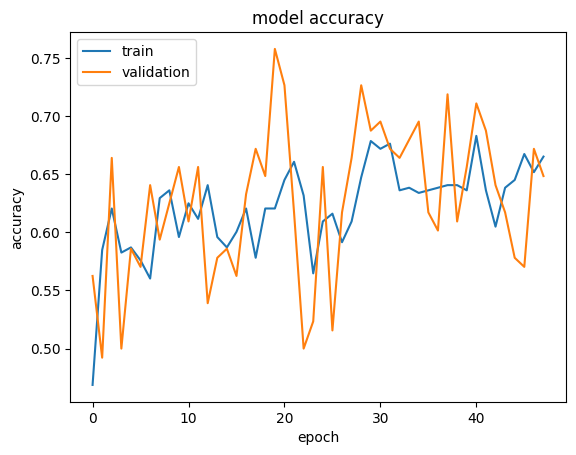

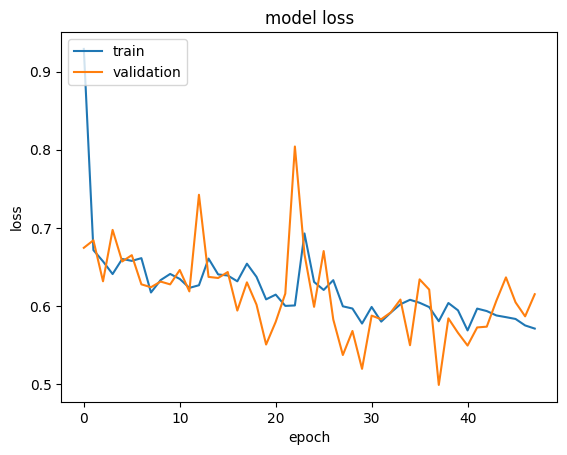

<Figure size 640x480 with 0 Axes>

In [6]:
dnn_model.metrics_names
 #  "Accuracy"
plt.plot(python_history.history['accuracy'])
plt.plot(python_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig(fig_path + 'accuracy_yt.jpg')
    # "Loss"
plt.plot(python_history.history['loss'])
plt.plot(python_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig(fig_path + 'loss_yt.jpg')

In [7]:
dnn_model.save(model_path + 'model_resnet_100.h5', overwrite=True)

In [8]:
test_dict = dnn_model.evaluate(
    test,
    steps=test_size,
    return_dict=True
)

2/2 [==============================] - 3s 198ms/step - loss: 0.6108 - accuracy: 0.6719


In [9]:
import tensorflow as tf
import os
#model = tf.keras.models.load_model("./new_model_spero_fighissimo")
converter = tf.lite.TFLiteConverter.from_keras_model(dnn_model)

tflite_quant_model = converter.convert()#save converted quantization model to tflite format
open(model_path + "model_yt.tflite", "wb").write(tflite_quant_model)

98689600